In [42]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o
import scipy as sp

## Result Gathering

In [43]:
main_df = None
directory = "Effort_Estimation_Results_3E_v2/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cas.csv
Cassandra.csv
Cxf.csv
Dbeaver.csv
Eclim.csv
Guacamole-client.csv
Hadoop.csv
Hawtio.csv
karaf.csv
Okhttp.csv
Openapi-generator.csv
Orientdb.csv
Redisson.csv
Rest-assured.csv
Spring-framework.csv
Spring-security.csv
Storm.csv
Tika.csv
Traccar.csv


In [44]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,2,NaN,8,1.000000,15.00000,4.13952,2.477916,12.48,42.435515
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,1,NaN,346,0.225434,1.00000,179.03424,107.076009,2229.76,519.589347
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,2,0.707107,35,1.000000,1.00000,18.11040,10.840124,189.60,113.234791
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,13,4.018895,194,0.185567,3.71134,100.38336,60.060503,1232.64,353.641141
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,136,50.585661,1938,0.004128,1.00000,1002.79872,597.273303,12673.28,1634.048307


In [45]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [46]:
len(main_df)

775

In [47]:
main_df['refactoring_perc_time_taken'] = main_df['refactoring_perc'] * main_df['time_taken']

In [48]:
def plotGraph(y_test,y_pred,y_test_str,y_pred_str,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

def plotGraphandSave(y_test,y_pred,y_test_str,y_pred_str,regressorName,img_name):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.savefig(f'model_prediction_images/{img_name}.png')
    plt.show()
    return





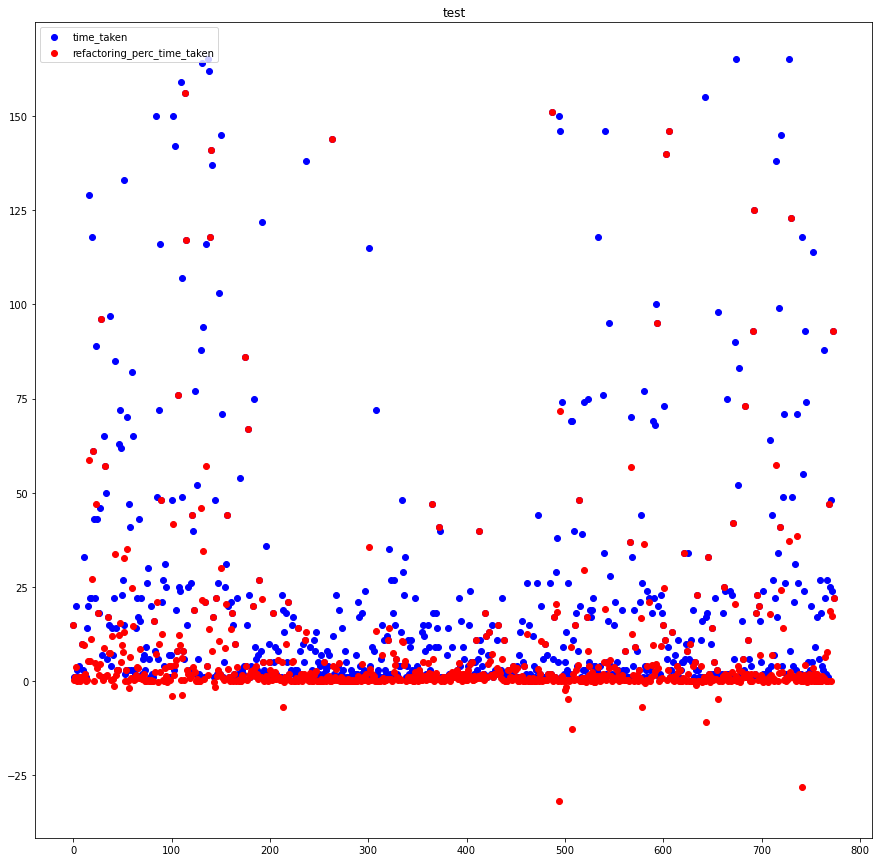

In [49]:
plotGraph(main_df['time_taken'], main_df['refactoring_perc_time_taken'],'time_taken','refactoring_perc_time_taken','test')

In [50]:
main_df = main_df[main_df['refactoring_perc_time_taken'] > 0]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 8]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 20]

#main_df = main_df[main_df['time_taken_final'] <= 60]
#main_df = main_df[main_df['time_taken_final'] > 2]

In [51]:
main_df['refactoring_perc_time_taken'].value_counts()

1.000000     27
2.000000     23
3.000000     11
5.000000      6
11.000000     6
             ..
0.245283      1
11.273423     1
0.199275      1
0.753363      1
0.171326      1
Name: refactoring_perc_time_taken, Length: 630, dtype: int64

In [52]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [53]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



In [54]:
#plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

{'whiskers': [<matplotlib.lines.Line2D at 0x20836ab6a90>,
 'caps': [<matplotlib.lines.Line2D at 0x20836aaa208>,
 'boxes': [<matplotlib.lines.Line2D at 0x20836ab6940>],
 'medians': [<matplotlib.lines.Line2D at 0x20836aaa908>],
 'fliers': [<matplotlib.lines.Line2D at 0x20836aaac50>],
 'means': []}

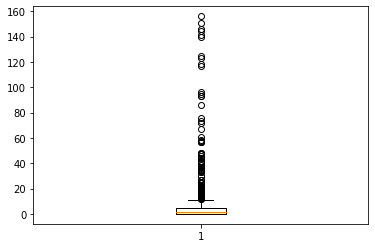

In [55]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

{'whiskers': [<matplotlib.lines.Line2D at 0x208336a1080>,
 'caps': [<matplotlib.lines.Line2D at 0x208337c59e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x208337dc668>],
 'medians': [<matplotlib.lines.Line2D at 0x208336cc390>],
 'fliers': [<matplotlib.lines.Line2D at 0x208336ccc88>],
 'means': []}

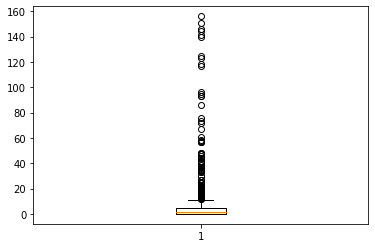

In [56]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [57]:
main_df['time_taken_final'].value_counts()

1.0     137
2.0      73
6.0      35
4.0      33
3.0      32
       ... 
1.8       1
39.9      1
20.4      1
8.4       1
54.0      1
Name: time_taken_final, Length: 119, dtype: int64

In [58]:
main_df = main_df.fillna(0)

In [59]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,time_taken_final
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.000000,8,1.000000,15.000000,4.13952,2.477916,12.48,42.435515,7.0
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,0.000000,346,0.225434,0.225434,179.03424,107.076009,2229.76,519.589347,0.0
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.707107,35,1.000000,1.000000,18.11040,10.840124,189.60,113.234791,0.0
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,13,4.018895,194,0.185567,3.711340,100.38336,60.060503,1232.64,353.641141,1.0
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,136,50.585661,1938,0.004128,0.012384,1002.79872,597.273303,12673.28,1634.048307,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,3,0.866025,16,0.750000,18.750000,8.27904,4.955729,64.96,67.284406,5.0
2,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,10,2.946898,1696,0.004127,0.198113,877.57824,523.020584,11085.76,1495.349884,9.0
3,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,1,0.000000,535,0.725234,17.405607,276.83040,165.484354,3469.60,694.272395,4.0
4,7,27.645283,1.0,157.0,2.0,4.0,5.0,8.2,13.0,17.0,...,1,0.000000,4,1.000000,93.000000,2.06976,1.238971,-13.76,26.763600,19.4


Text(0.5, 1.0, 'Distribution of time for Refactoring Operations')

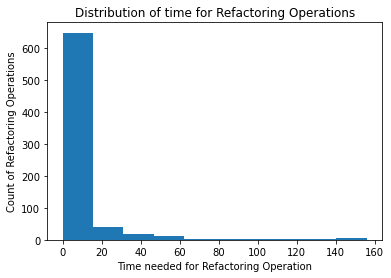

In [60]:
plt.hist(main_df['refactoring_perc_time_taken'])
plt.ylabel('Count of Refactoring Operations')
plt.xlabel('Time needed for Refactoring Operation')
plt.title('Distribution of time for Refactoring Operations')

Text(0.5, 1.0, 'Distribution of ln(time) for Refactoring Operations')

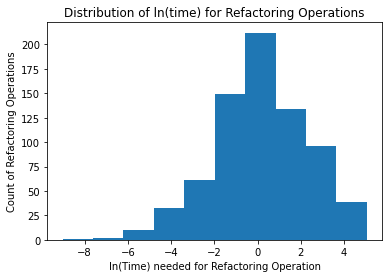

In [61]:
main_df['refactoring_perc_time_taken_log'] = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(main_df['refactoring_perc_time_taken_log'])
plt.ylabel('Count of Refactoring Operations')
plt.xlabel('ln(Time) needed for Refactoring Operation')
plt.title('Distribution of ln(time) for Refactoring Operations')

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  2.,  5.,  2.,  8.,
         4.,  8., 13., 12., 15., 17., 17., 28., 45., 35., 41., 36., 64.,
        48., 64., 40., 39., 34., 21., 33., 28., 21., 14., 14., 10.,  5.,
        10.]),
 array([-9.02114525, -8.66937021, -8.31759518, -7.96582015, -7.61404512,
        -7.26227009, -6.91049506, -6.55872003, -6.206945  , -5.85516996,
        -5.50339493, -5.1516199 , -4.79984487, -4.44806984, -4.09629481,
        -3.74451978, -3.39274474, -3.04096971, -2.68919468, -2.33741965,
        -1.98564462, -1.63386959, -1.28209456, -0.93031953, -0.57854449,
        -0.22676946,  0.12500557,  0.4767806 ,  0.82855563,  1.18033066,
         1.53210569,  1.88388073,  2.23565576,  2.58743079,  2.93920582,
         3.29098085,  3.64275588,  3.99453091,  4.34630594,  4.69808098,
         5.04985601]),
 <a list of 40 Patch objects>)

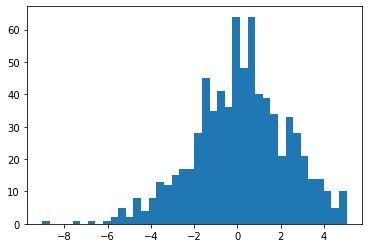

In [62]:
plt.hist(main_df['refactoring_perc_time_taken_log'],bins=40)

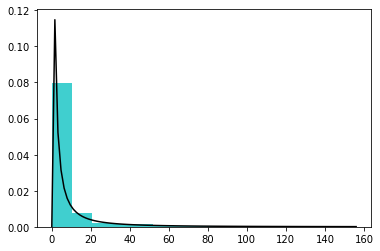

In [63]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=15, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

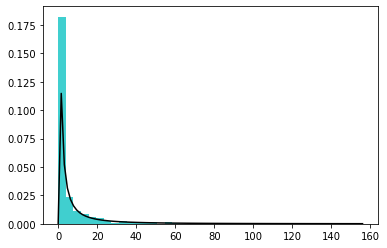

In [64]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=40, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

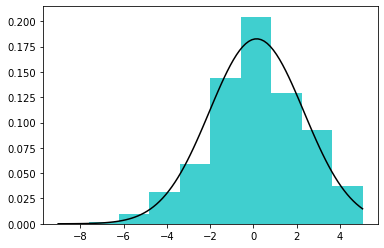

In [65]:
logdata = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(logdata, bins=10, density=True, color='c', alpha=0.75)
xmin = logdata.min()
xmax = logdata.max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')

In [66]:
len(main_df)

737

In [67]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [68]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [69]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [70]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc',
 'cocomoII_time_taken',
'geneticP_time_taken',
'softwareMaintenance_time_taken',
'fuzzy_time_taken',
'time_taken_final',
'refactoring_perc_time_taken'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [71]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [72]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken_log')
Y_col = ['refactoring_perc_time_taken_log']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [73]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,11.000000,11.0,11.0,0.000000,8.000000,8.0,8.0,0.000000,2.000000,2.0,...,58.000000,58.0,58.0,0.000000,17.000000,17.0,17.0,0.000000,85.000000,61.000000
1,12.000000,12.0,12.0,0.000000,8.000000,8.0,8.0,0.000000,1.000000,1.0,...,68.000000,68.0,68.0,0.000000,17.000000,17.0,17.0,0.000000,3.000000,78.000000
2,30.000000,30.0,30.0,0.000000,29.000000,29.0,29.0,0.000000,1.000000,1.0,...,103.000000,103.0,103.0,0.000000,1.000000,1.0,1.0,0.000000,78.000000,322.000000
3,23.250000,5.0,63.0,20.780782,20.666667,4.0,64.0,21.993112,2.000000,1.0,...,121.333333,37.0,320.0,98.919006,1.000000,1.0,1.0,0.000000,57.583333,222.666667
4,7.833333,0.0,31.0,11.027514,7.833333,1.0,21.0,7.444746,1.166667,1.0,...,63.500000,8.0,125.0,36.335557,10.333333,1.0,17.0,8.238858,54.333333,88.000000


In [74]:
y.head()

,refactoring_perc_time_taken_log
0,2.708050
1,-1.489730
2,0.000000
3,1.311393
4,-4.391358


In [75]:
final_df.head(10)

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken_log
0,11.000000,11.0,11.0,0.000000,8.000000,8.0,8.0,0.000000,2.000000,2.0,...,58.0,58.0,0.000000,17.000000,17.0,17.0,0.000000,85.000000,61.000000,2.708050
1,12.000000,12.0,12.0,0.000000,8.000000,8.0,8.0,0.000000,1.000000,1.0,...,68.0,68.0,0.000000,17.000000,17.0,17.0,0.000000,3.000000,78.000000,-1.489730
2,30.000000,30.0,30.0,0.000000,29.000000,29.0,29.0,0.000000,1.000000,1.0,...,103.0,103.0,0.000000,1.000000,1.0,1.0,0.000000,78.000000,322.000000,0.000000
3,23.250000,5.0,63.0,20.780782,20.666667,4.0,64.0,21.993112,2.000000,1.0,...,37.0,320.0,98.919006,1.000000,1.0,1.0,0.000000,57.583333,222.666667,1.311393
4,7.833333,0.0,31.0,11.027514,7.833333,1.0,21.0,7.444746,1.166667,1.0,...,8.0,125.0,36.335557,10.333333,1.0,17.0,8.238858,54.333333,88.000000,-4.391358
5,25.000000,25.0,25.0,0.000000,32.000000,32.0,32.0,0.000000,1.000000,1.0,...,166.0,166.0,0.000000,1025.000000,1025.0,1025.0,0.000000,51.000000,321.000000,-0.144761
6,8.000000,8.0,8.0,0.000000,8.000000,8.0,8.0,0.000000,1.000000,1.0,...,50.0,50.0,0.000000,1.000000,1.0,1.0,0.000000,642.000000,48.000000,0.092709
7,27.666667,3.0,76.0,41.860881,50.000000,1.0,140.0,78.044859,1.666667,1.0,...,36.0,407.0,202.230067,1.000000,1.0,1.0,0.000000,69.333333,458.666667,-4.500735
8,43.000000,43.0,43.0,0.000000,18.000000,18.0,18.0,0.000000,1.000000,1.0,...,125.0,125.0,0.000000,17.000000,17.0,17.0,0.000000,65.500000,242.000000,0.000000
9,38.000000,38.0,38.0,0.000000,57.000000,57.0,57.0,0.000000,1.000000,1.0,...,279.0,279.0,0.000000,17.000000,17.0,17.0,0.000000,322.000000,764.000000,2.302585


In [76]:
final_df = final_df.sample(frac=1).reset_index(drop=True)

In [77]:
final_df.head(10)

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken_log
0,8.000000,0.0,19.0,6.468860,10.142857,3.0,17.0,4.638586,2.000000,1.0,...,36.0,175.0,42.745156,147.285714,1.0,1025.0,371.851796,37.142857,130.142857,-0.497885
1,5.000000,5.0,5.0,0.000000,1.000000,1.0,1.0,0.000000,1.000000,1.0,...,61.0,61.0,0.000000,1.000000,1.0,1.0,0.000000,18.333333,51.000000,2.397895
2,27.000000,27.0,27.0,0.000000,9.000000,9.0,9.0,0.000000,6.000000,6.0,...,177.0,177.0,0.000000,0.000000,0.0,0.0,0.000000,13.000000,338.000000,3.018708
3,16.333333,10.0,22.0,6.027714,6.666667,3.0,12.0,4.725816,3.000000,3.0,...,29.0,100.0,35.763109,1.000000,1.0,1.0,0.000000,168.666667,100.333333,-0.021979
4,7.185185,6.0,9.0,1.401806,0.166667,0.0,1.0,0.376177,1.611111,1.0,...,22.0,193.0,39.364217,1.000000,1.0,1.0,0.000000,50.981481,42.722222,-3.429012
5,21.000000,21.0,21.0,0.000000,2.000000,2.0,2.0,0.000000,1.000000,1.0,...,27.0,27.0,0.000000,1.000000,1.0,1.0,0.000000,18.000000,42.000000,0.405465
6,5.500000,4.0,7.0,2.121320,1.500000,1.0,2.0,0.707107,3.000000,3.0,...,11.0,21.0,7.071068,1.000000,1.0,1.0,0.000000,10.000000,14.500000,1.355989
7,16.000000,16.0,16.0,0.000000,76.333333,75.0,77.0,1.154701,5.000000,5.0,...,188.0,194.0,3.464102,1.000000,1.0,1.0,0.000000,160.000000,499.000000,0.000000
8,4.666667,0.0,10.0,4.186814,25.277778,4.0,68.0,22.694403,1.000000,1.0,...,25.0,243.0,73.748579,1.000000,1.0,1.0,0.000000,35.666667,111.833333,1.938363
9,10.625000,5.0,17.0,4.759202,6.250000,2.0,15.0,4.187282,2.875000,2.0,...,19.0,97.0,25.180680,1.000000,1.0,1.0,0.000000,56.687500,99.000000,0.543335


## Feature Engineering

In [78]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,26 mins 43 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,9 months and 28 days !!!
H2O_cluster_name:,H2O_from_python_tanji_bzsril
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.982 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [79]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.8], seed=16)


x = final_col
y = "refactoring_perc_time_taken_log"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [81]:
full.shape

(737, 163)

In [84]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [85]:
train[y].types

{'refactoring_perc_time_taken_log': 'real'}

In [86]:
aml = H2OAutoML(max_models=25, seed=16, exclude_algos=['XGBoost'], exploitation_ratio=0.1)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |█████████████████████████████████████████████████Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tanji\\AppData\\Local\\Temp\\tmpxl0fza1p.csv'
███████| 100%


In [87]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20220701_094553,3.79195,1.94729,3.79195,1.55685,nan
GBM_lr_annealing_selection__AutoML_20220701_094553_select_model,3.81298,1.95268,3.81298,1.54727,nan
GBM_grid__1_AutoML_20220701_094553_model_3,3.82234,1.95508,3.82234,1.54855,nan
StackedEnsemble_AllModels_AutoML_20220701_094553,3.89886,1.97455,3.89886,1.56133,nan
DeepLearning_grid__3_AutoML_20220701_094553_model_1,3.94638,1.98655,3.94638,1.59794,nan
GBM_grid__1_AutoML_20220701_094553_model_4,3.95735,1.98931,3.95735,1.59311,nan
GBM_2_AutoML_20220701_094553,3.97924,1.9948,3.97924,1.58686,nan
GBM_grid__1_AutoML_20220701_094553_model_1,3.9802,1.99504,3.9802,1.59393,nan
DRF_1_AutoML_20220701_094553,3.99302,1.99826,3.99302,1.59241,nan
GBM_grid__1_AutoML_20220701_094553_model_2,4.00553,2.00138,4.00553,1.59721,nan


stackedensemble prediction progress: |████████████████████████████████████| 100%


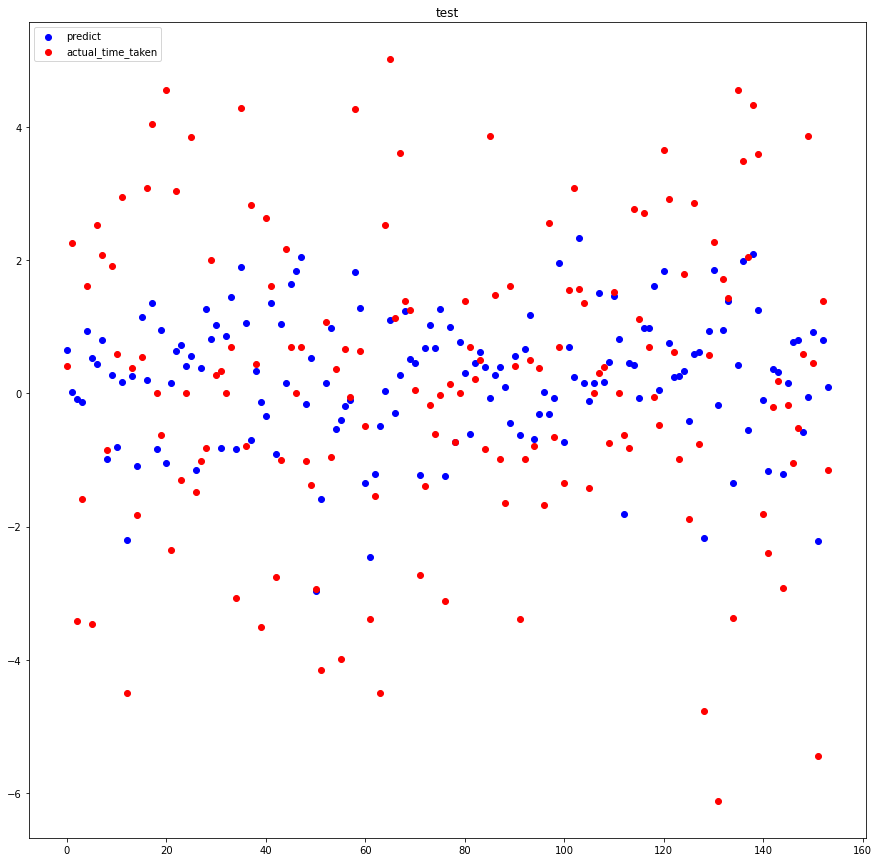

gbm prediction progress: |████████████████████████████████████████████████| 100%


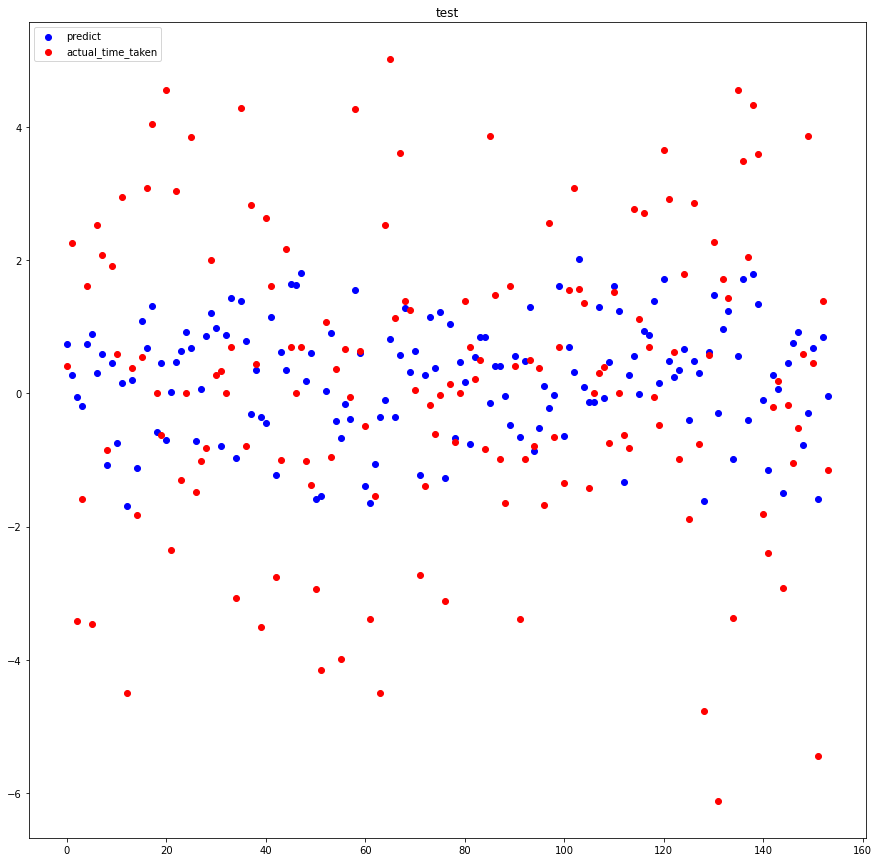

gbm prediction progress: |████████████████████████████████████████████████| 100%


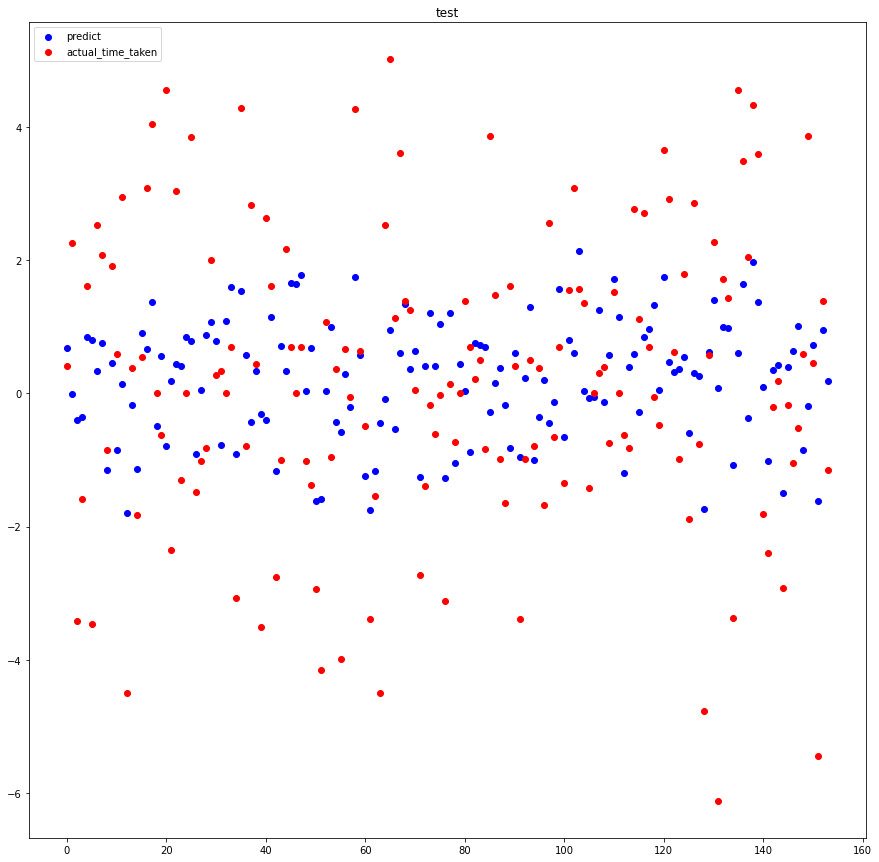

stackedensemble prediction progress: |████████████████████████████████████| 100%


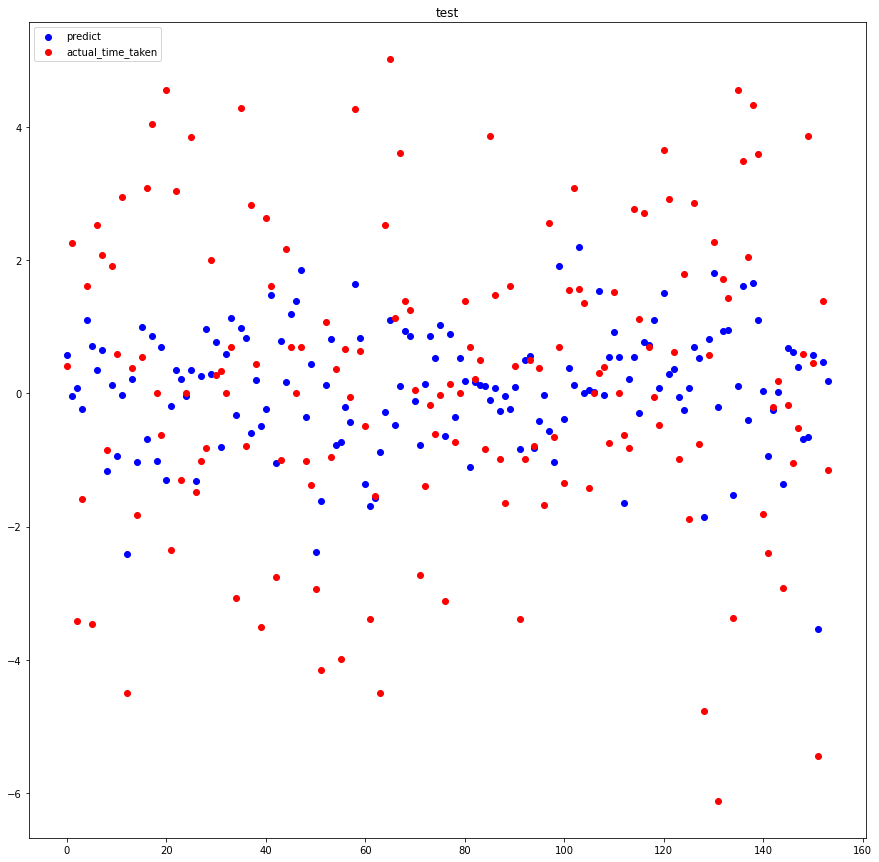

deeplearning prediction progress: |███████████████████████████████████████| 100%


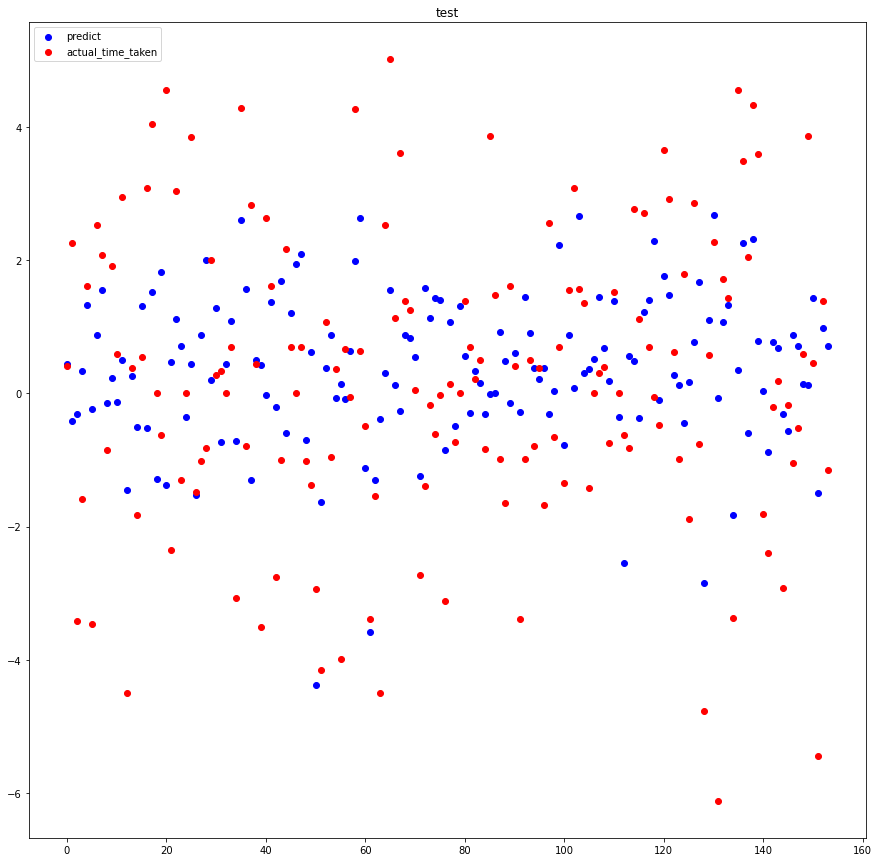

gbm prediction progress: |████████████████████████████████████████████████| 100%


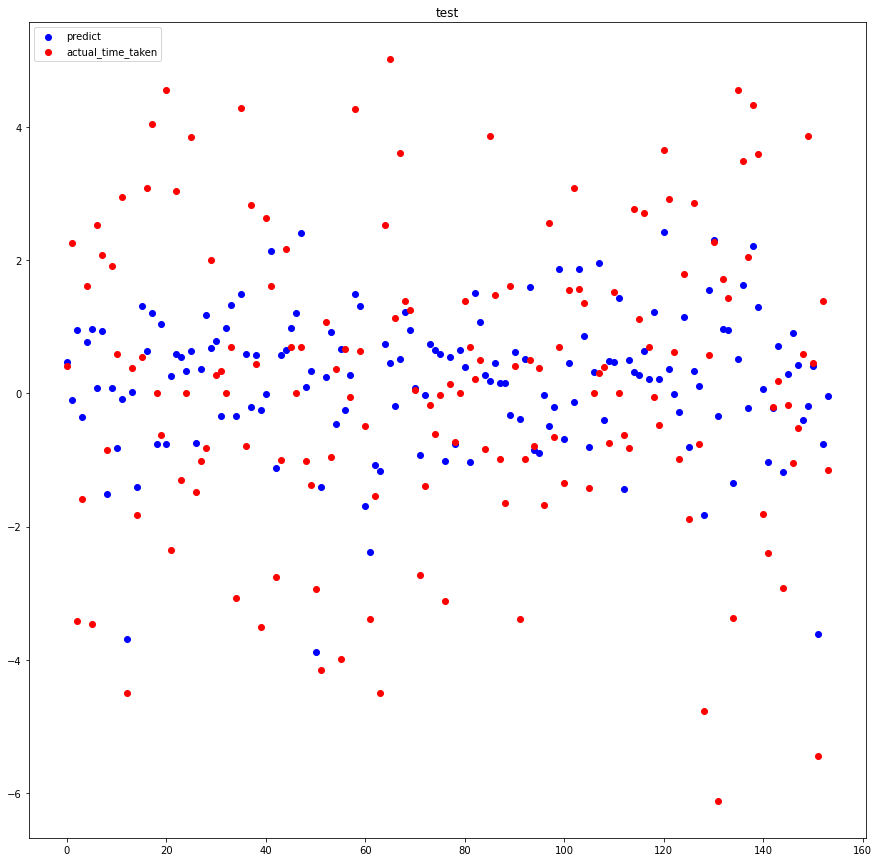

gbm prediction progress: |████████████████████████████████████████████████| 100%


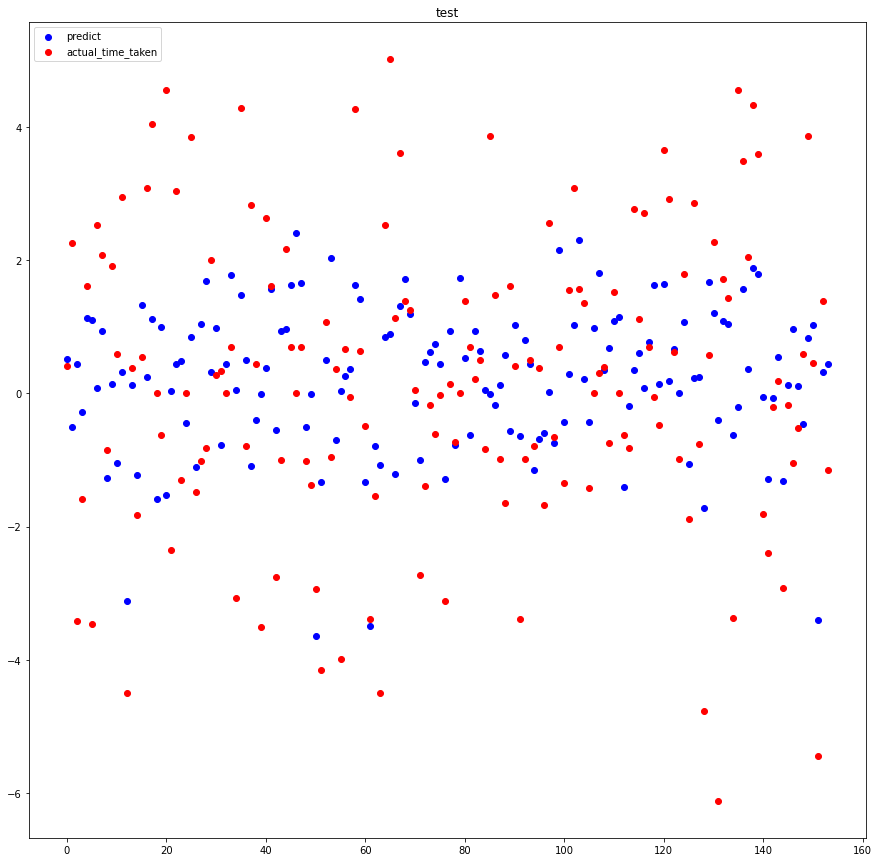

gbm prediction progress: |████████████████████████████████████████████████| 100%


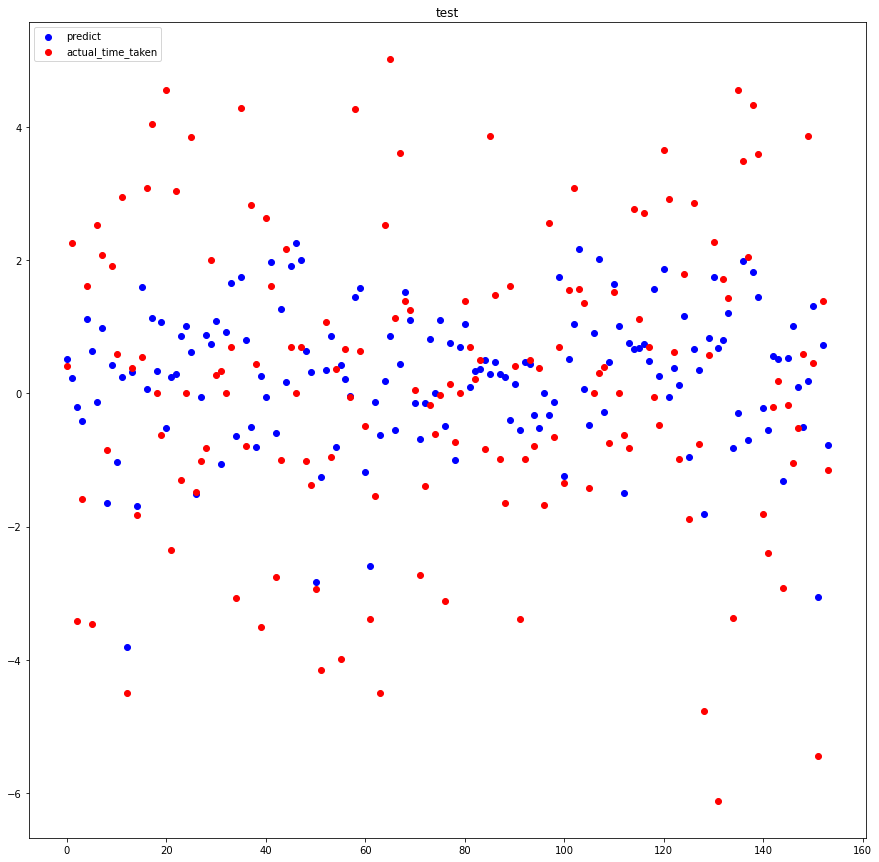

drf prediction progress: |████████████████████████████████████████████████| 100%


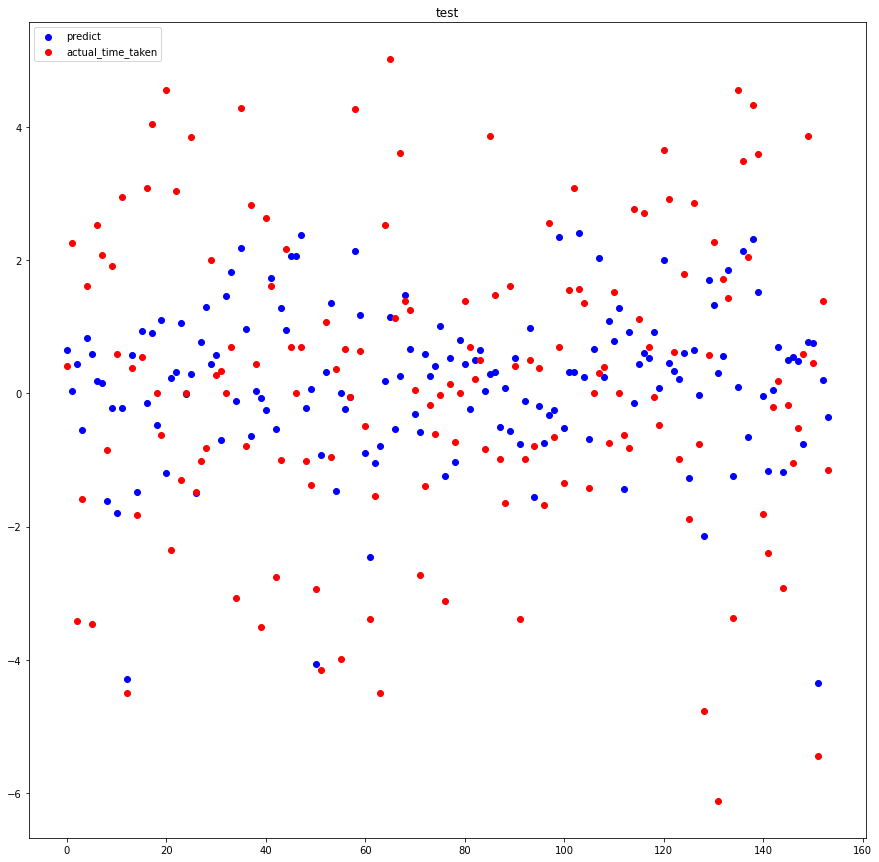

gbm prediction progress: |████████████████████████████████████████████████| 100%


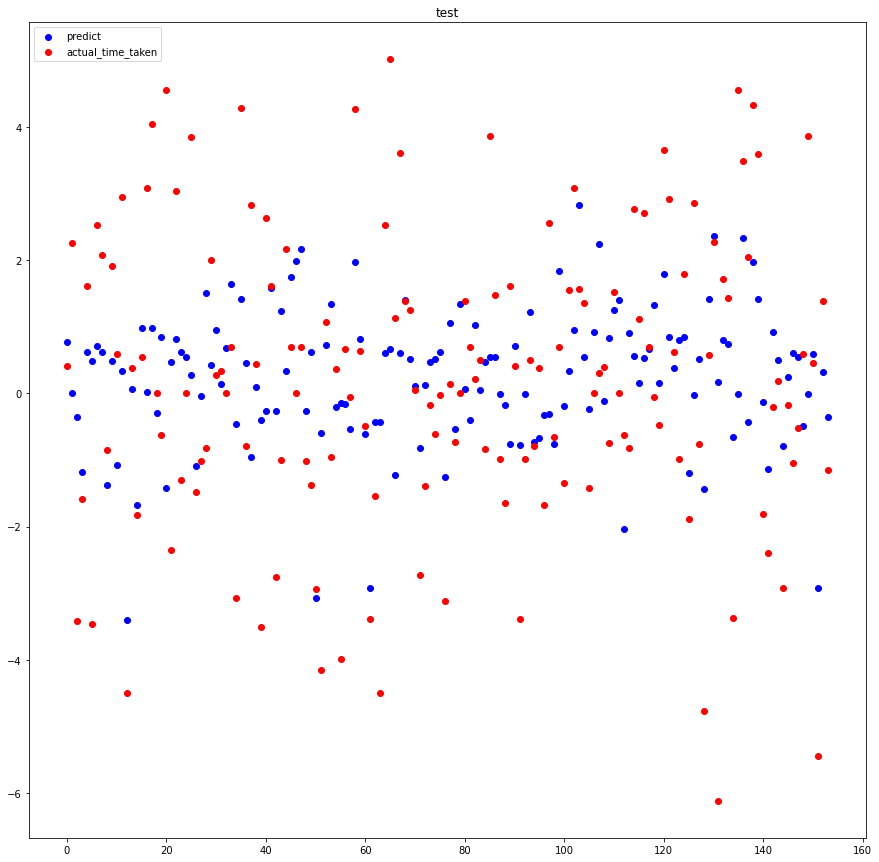

deeplearning prediction progress: |███████████████████████████████████████| 100%


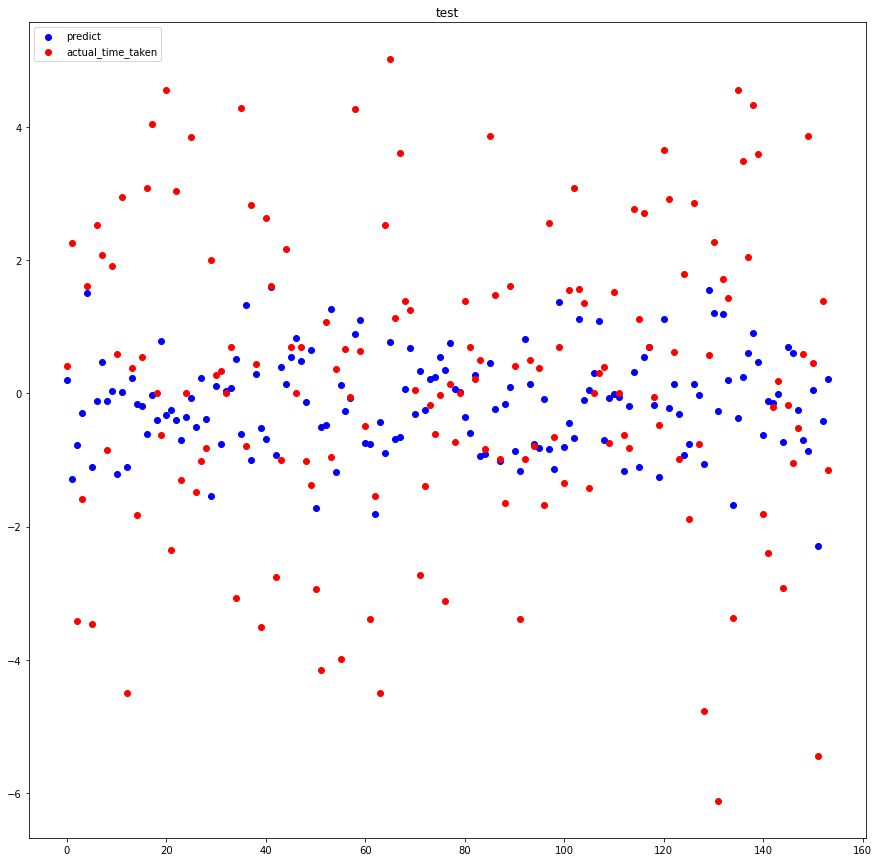

gbm prediction progress: |████████████████████████████████████████████████| 100%


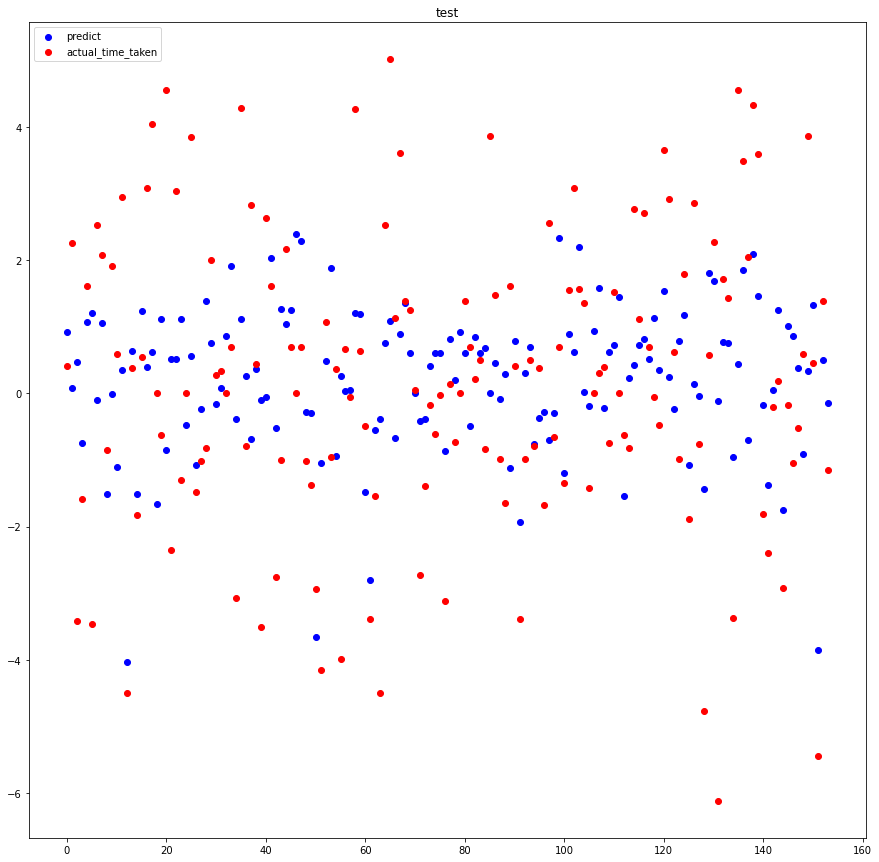

drf prediction progress: |████████████████████████████████████████████████| 100%


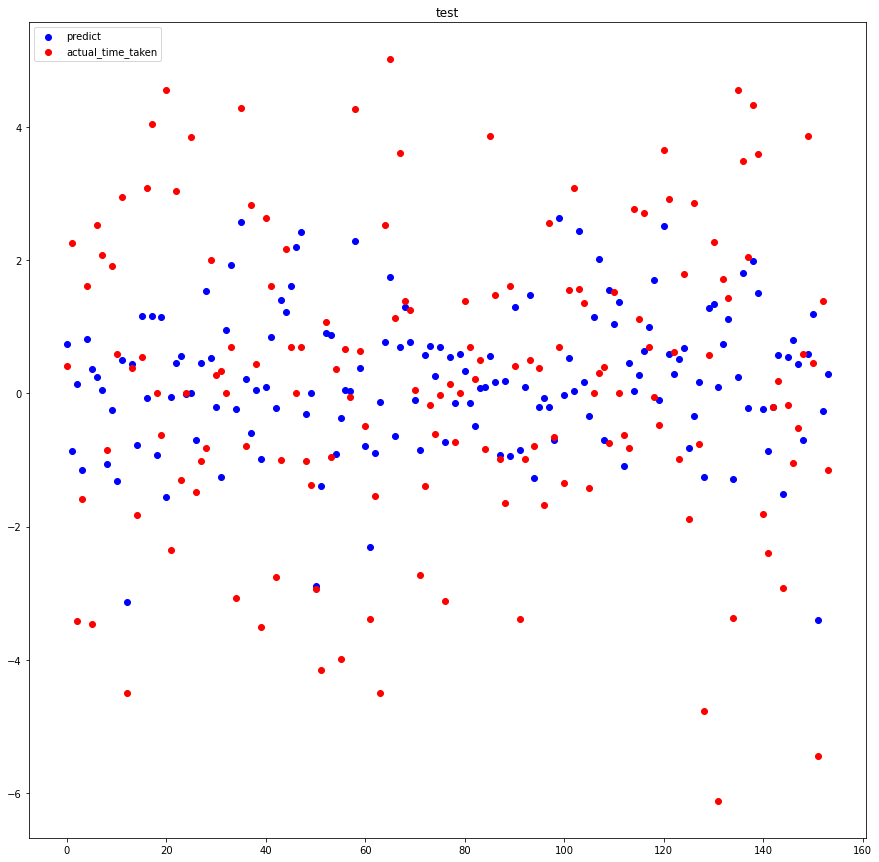

gbm prediction progress: |████████████████████████████████████████████████| 100%


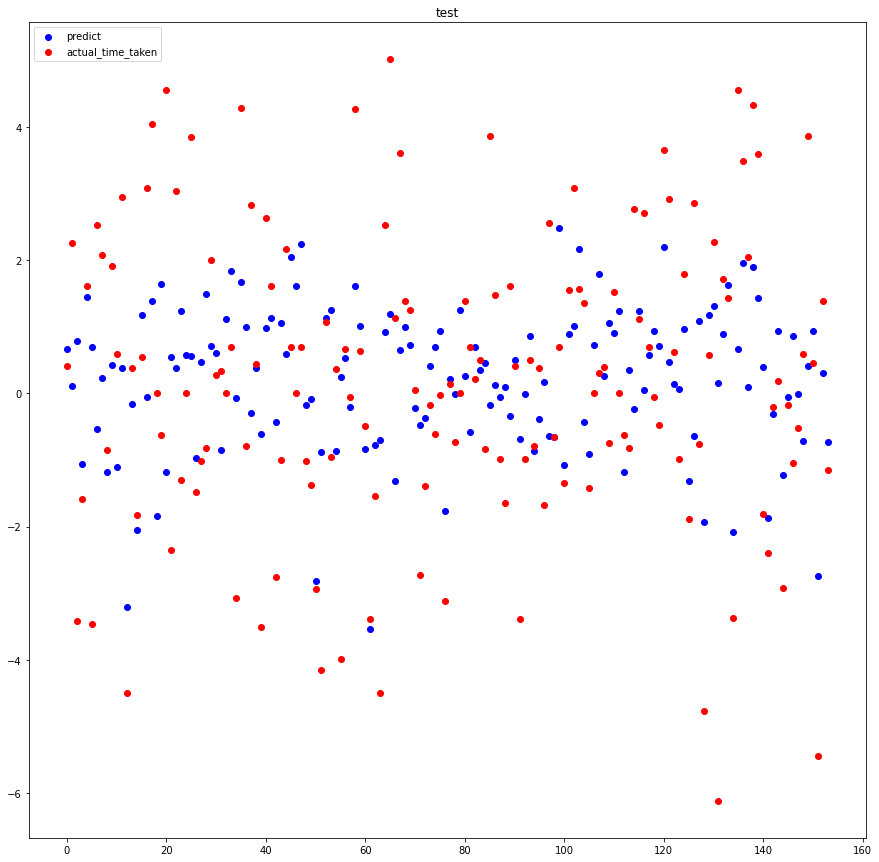

gbm prediction progress: |████████████████████████████████████████████████| 100%


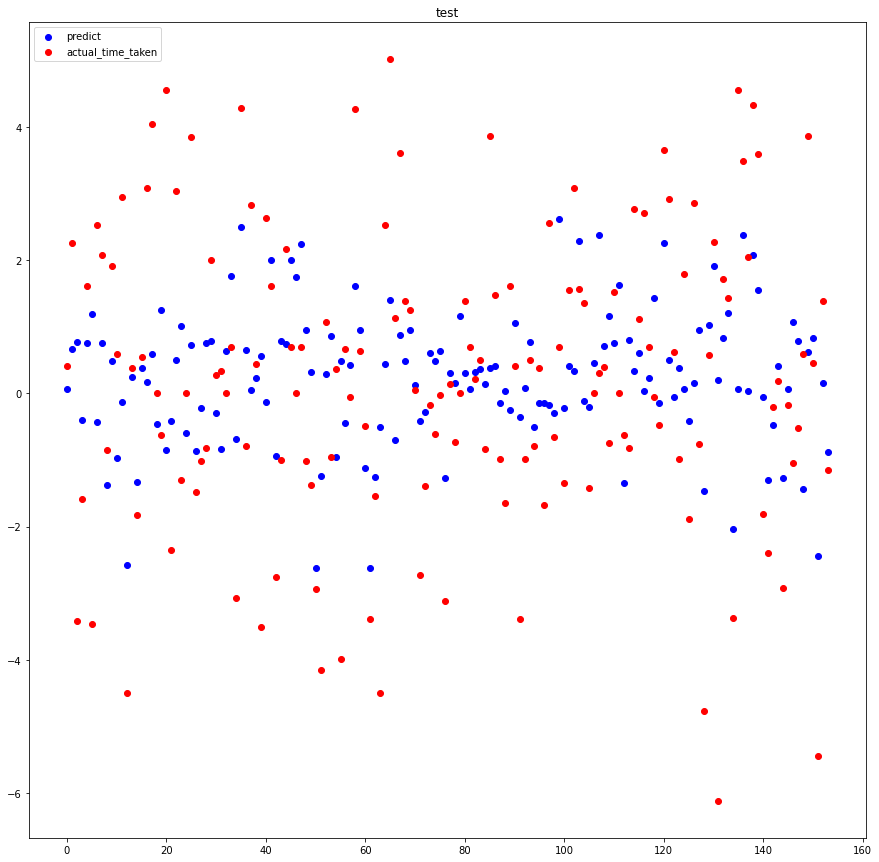

gbm prediction progress: |████████████████████████████████████████████████| 100%


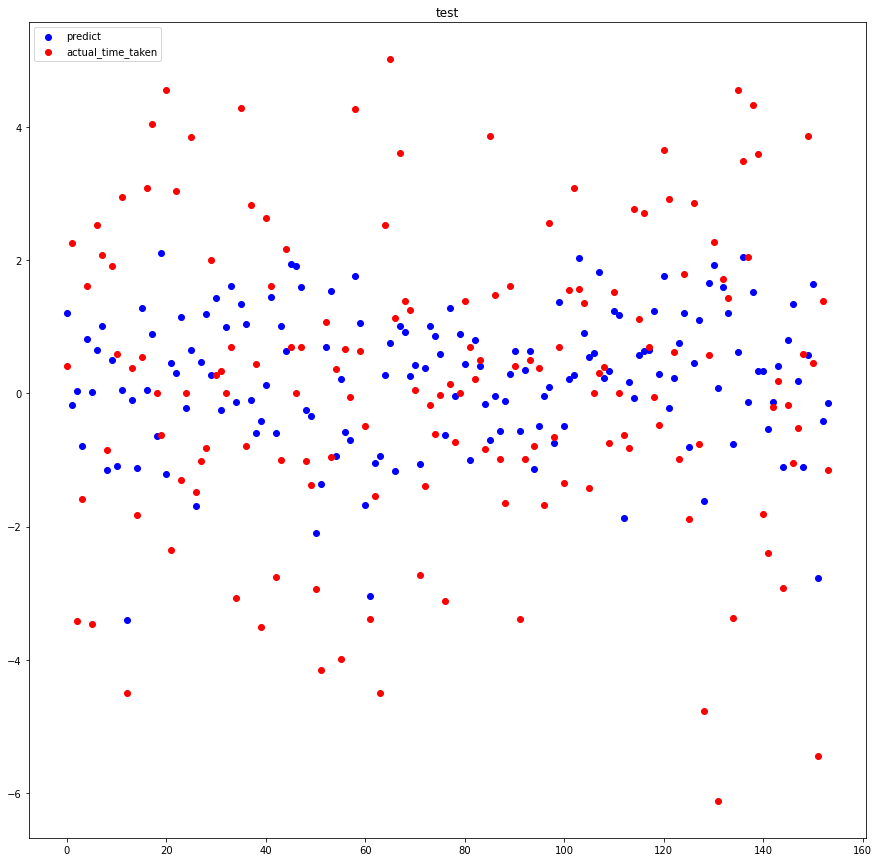

gbm prediction progress: |████████████████████████████████████████████████| 100%


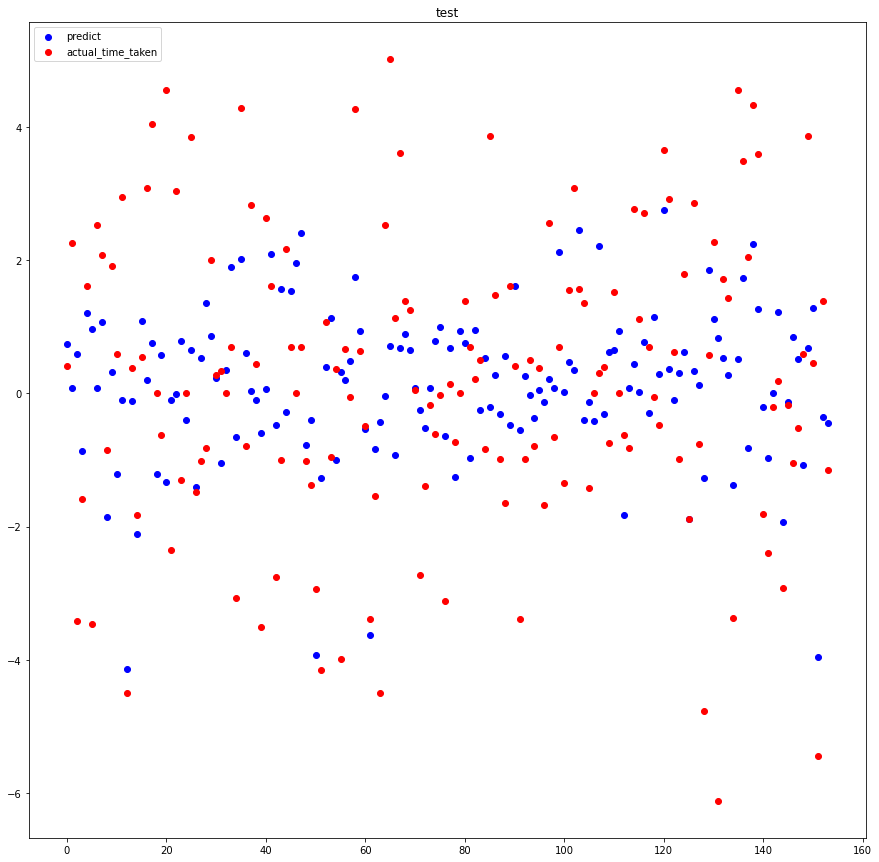

gbm prediction progress: |████████████████████████████████████████████████| 100%


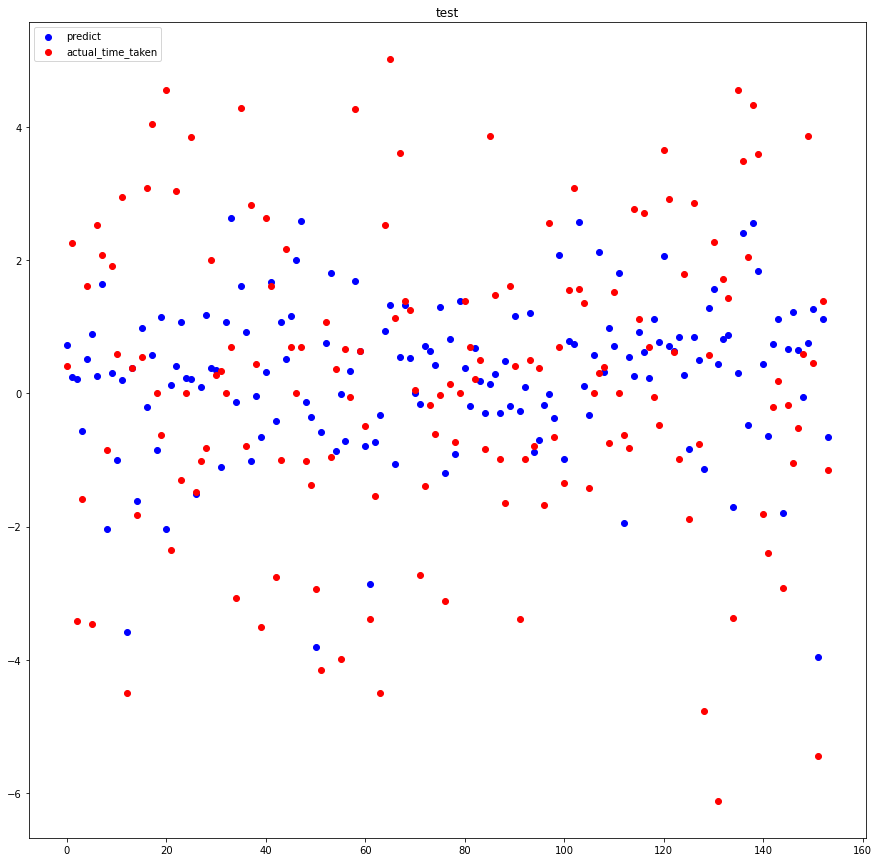

deeplearning prediction progress: |███████████████████████████████████████| 100%


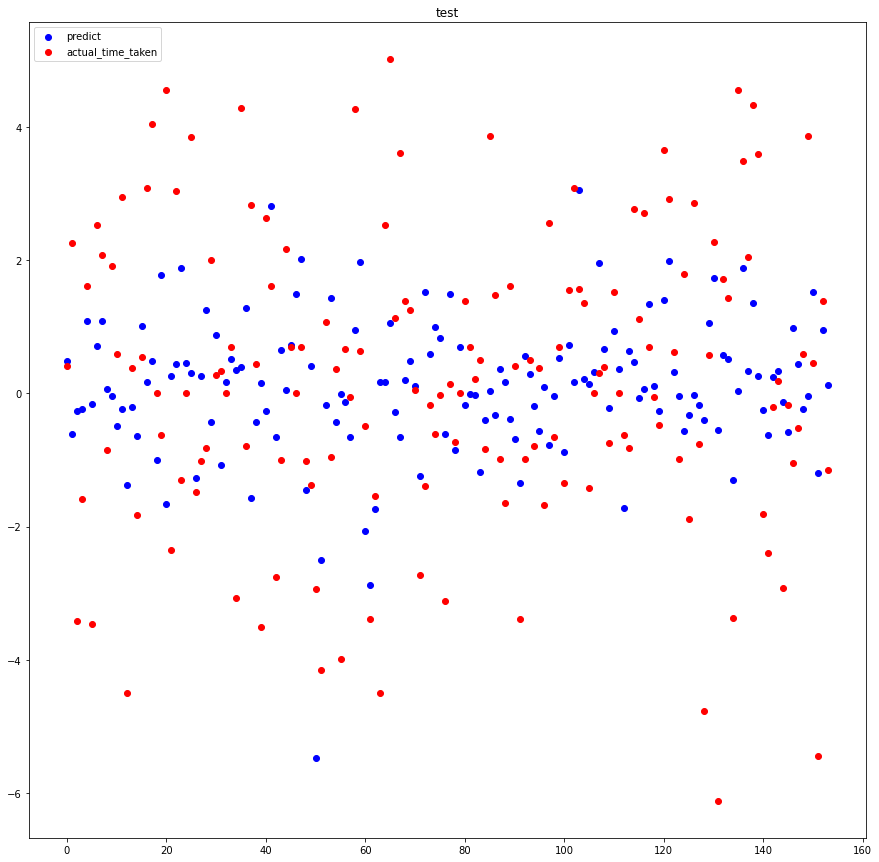

deeplearning prediction progress: |███████████████████████████████████████| 100%


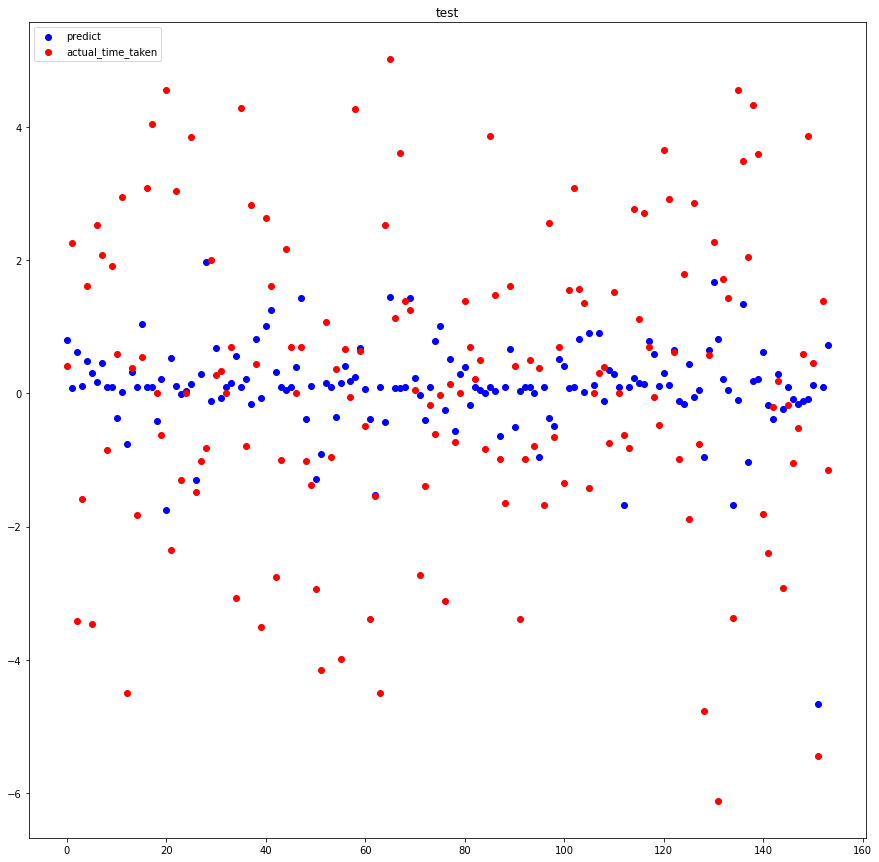

glm prediction progress: |████████████████████████████████████████████████| 100%


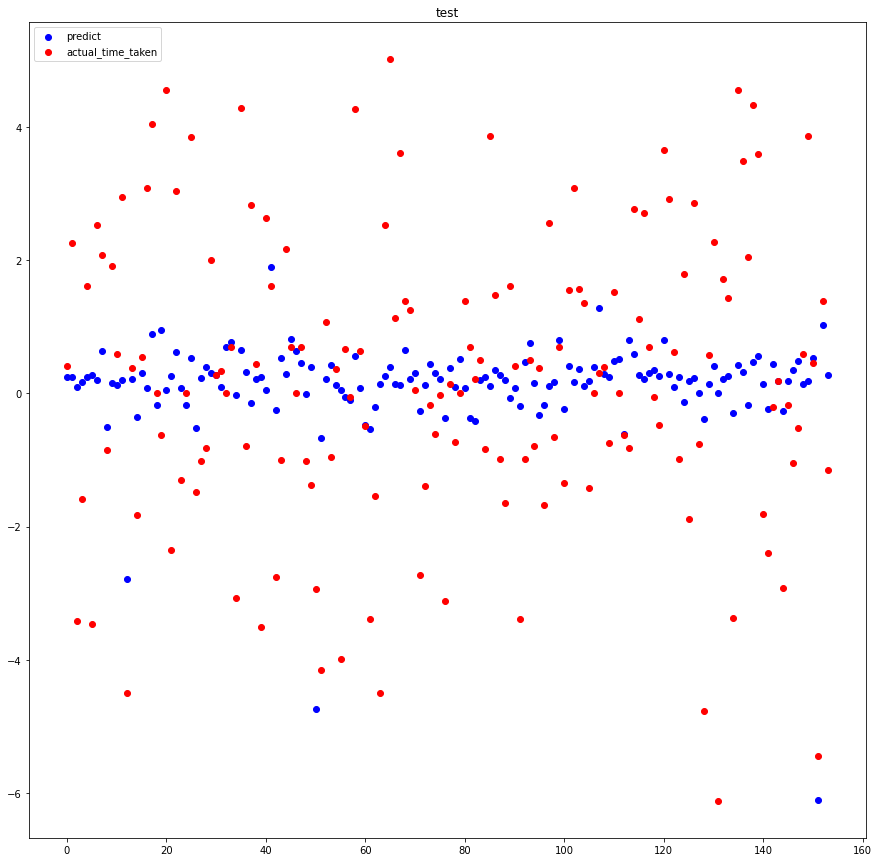

deeplearning prediction progress: |███████████████████████████████████████| 100%


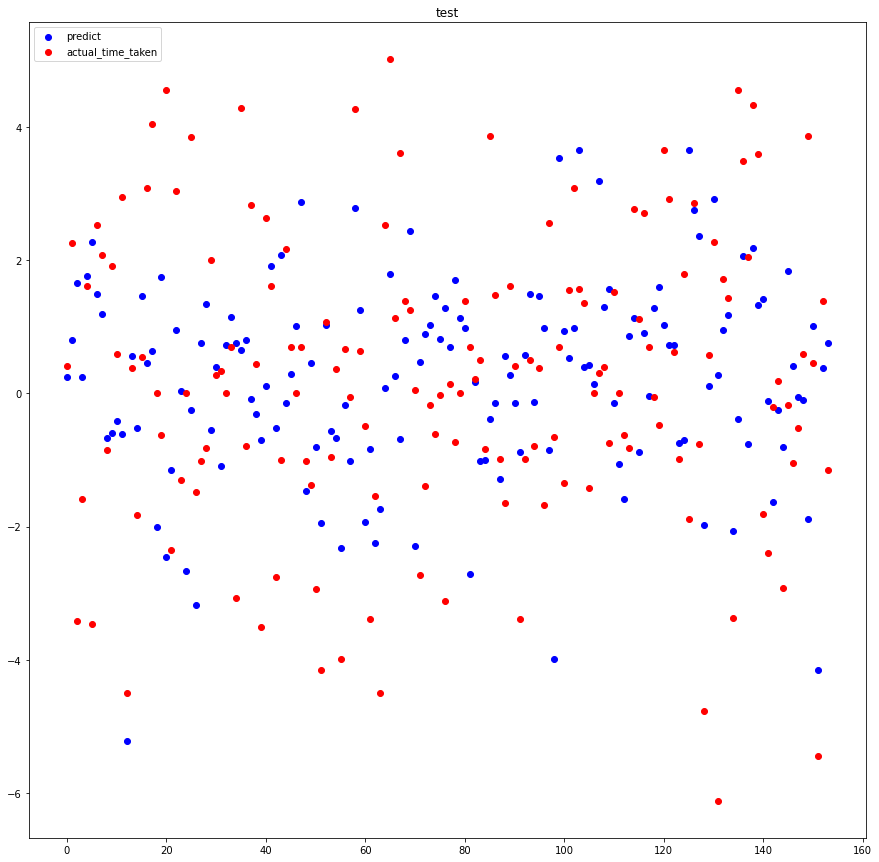

deeplearning prediction progress: |███████████████████████████████████████| 100%


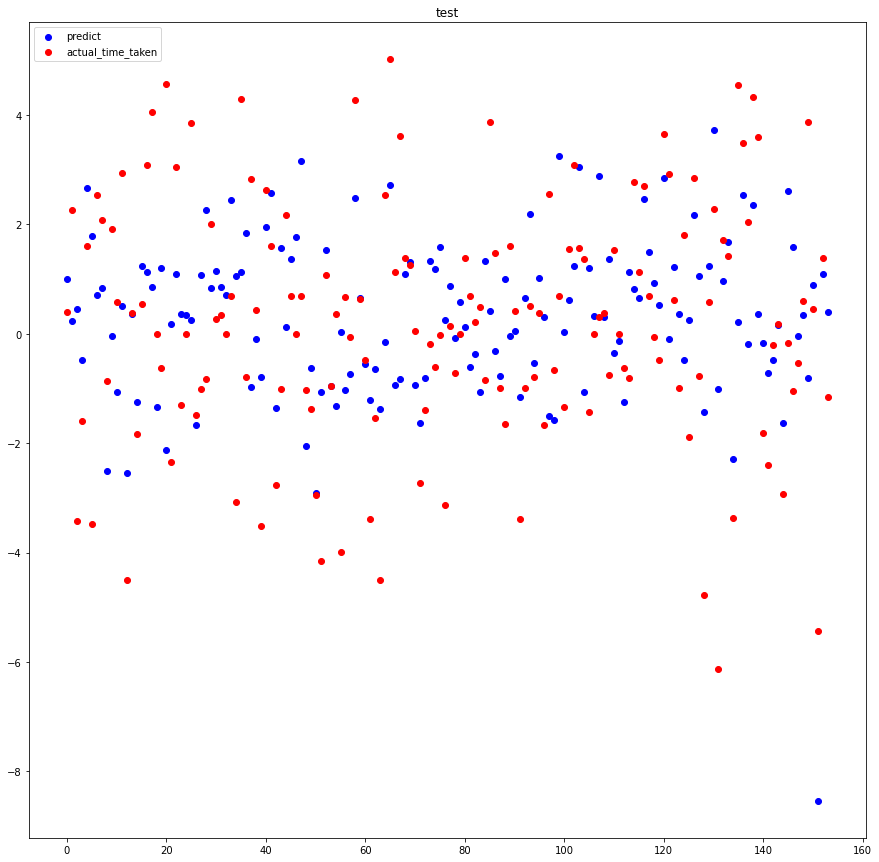

deeplearning prediction progress: |███████████████████████████████████████| 100%


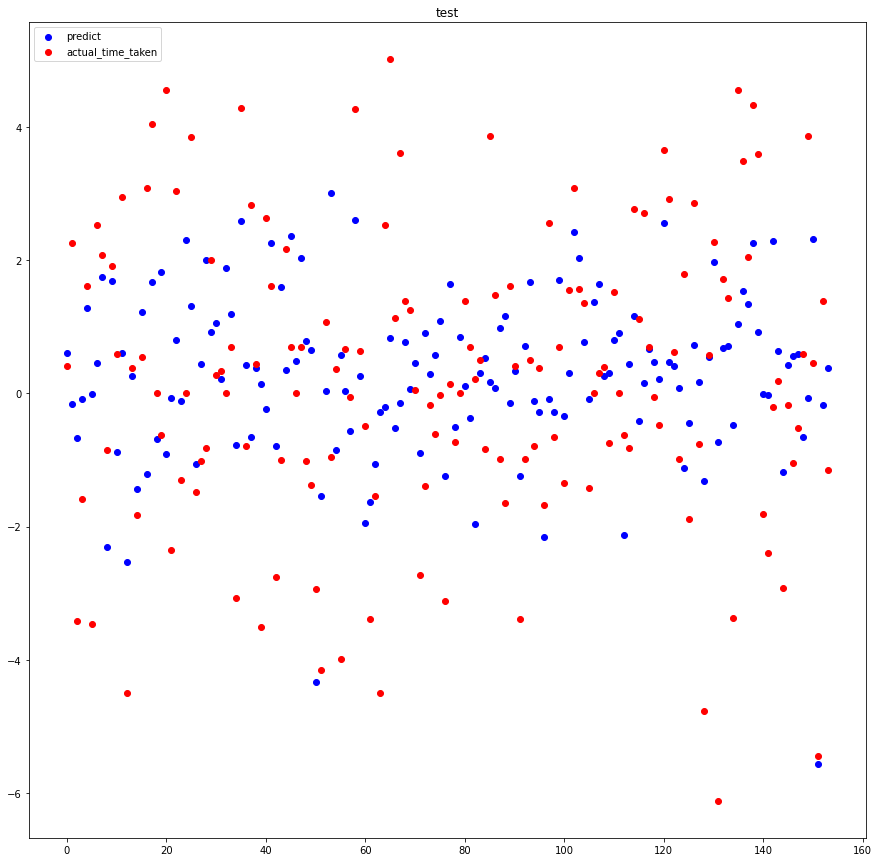

deeplearning prediction progress: |███████████████████████████████████████| 100%


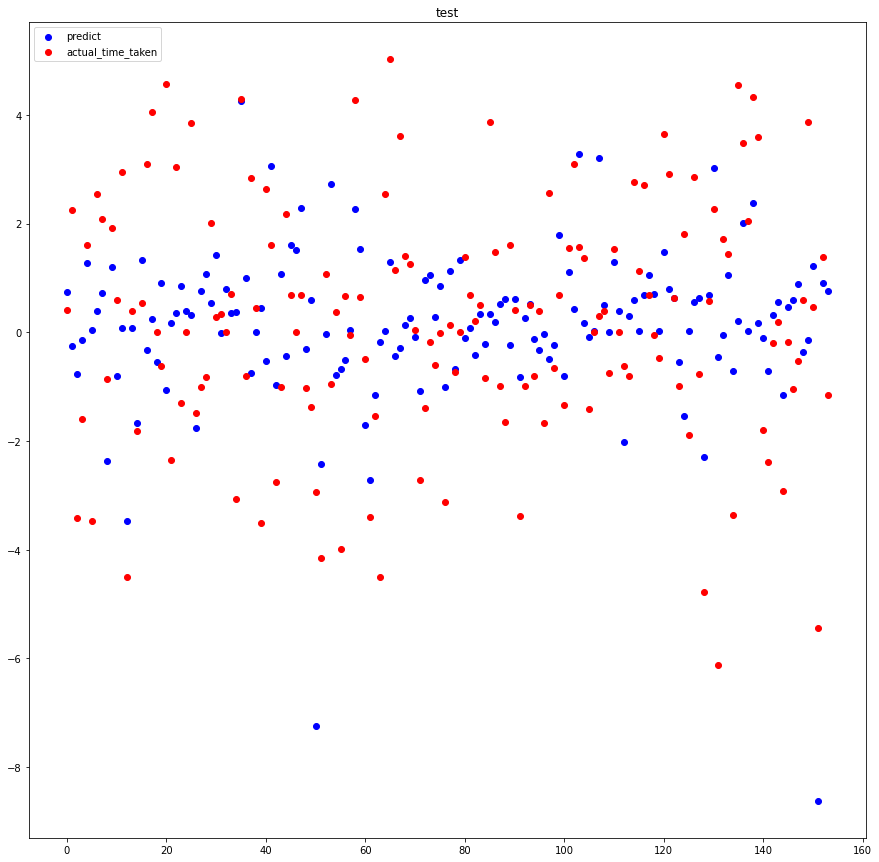

In [88]:
for i in range(25):
    model = h2o.get_model(lb[i,'model_id'])
    preds = model.predict(test)
    pd_preds = preds.as_data_frame()
    pd_test = test.as_data_frame()
    pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken_log']
    #pd_preds.loc[(pd_preds.predict < 0),'predict']=1
    plotGraphandSave(pd_preds['predict'], pd_preds['actual_time_taken'],'predict','actual_time_taken','test', i)
    

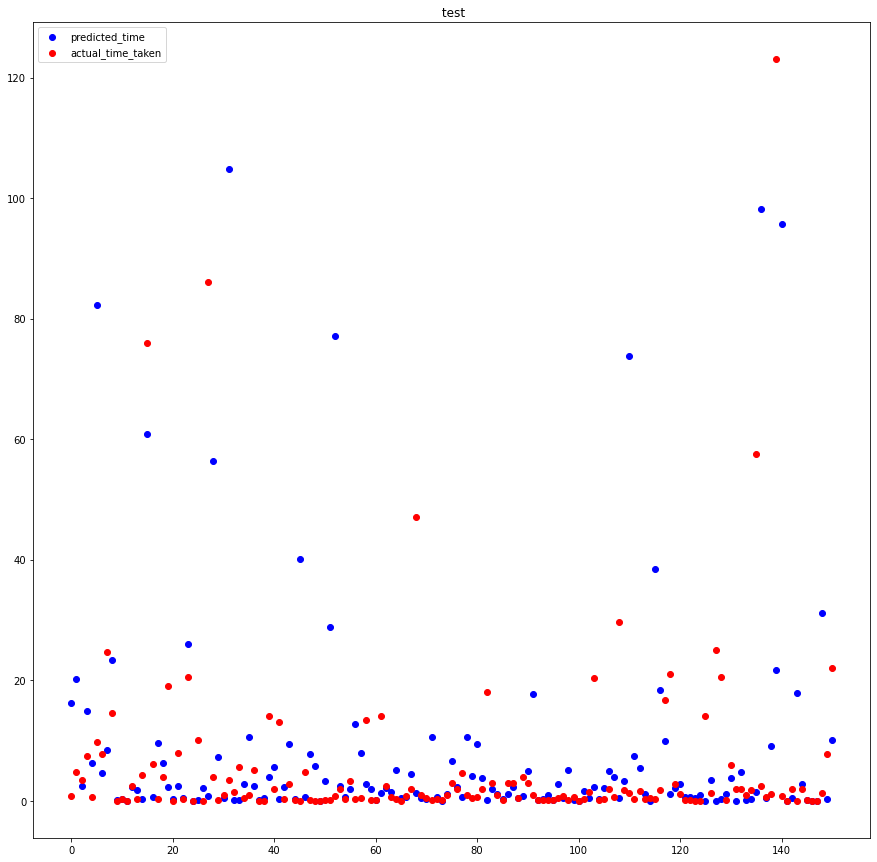

In [77]:
visualization = pd_preds[pd_preds['predict'] <= 5]
#visualization = pd_preds[pd_preds['actual_time_taken'] <= 20]
plotGraph(np.exp(visualization['predict']), np.exp(visualization['actual_time_taken']),'predicted_time','actual_time_taken',' test')

In [89]:
model = h2o.get_model(lb[0,'model_id'])

In [90]:
model

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20220701_094553

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 2.1611191858674452
RMSE: 1.4700745511257058
MAE: 1.1544039064093323
RMSLE: NaN
R^2: 0.5439045664648665
Mean Residual Deviance: 2.1611191858674452
Null degrees of freedom: 582
Residual degrees of freedom: 578
Null deviance: 2762.431703372162
Residual deviance: 1259.9324853607206
AIC: 2115.757421289155

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 3.7919475504822944
RMSE: 1.9472923638946193
MAE: 1.556851751354825
RMSLE: NaN
R^2: 0.1997248586335999
Mean Residual Deviance: 3.7919475504822944
Null degrees of freedom: 582
Residual degrees of freedom: 579
Null deviance: 2769.3191676317783
Residual deviance: 2210.7054219311776
AIC: 2441.5512255251533


In [91]:
preds = model.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [92]:
preds.shape

(154, 1)

In [93]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

-0.313405    1
 1.354589    1
 1.394584    1
 0.694858    1
 0.980356    1
            ..
 0.991683    1
 0.661460    1
-0.071198    1
-0.443620    1
-0.984653    1
Name: predict, Length: 154, dtype: int64

In [94]:
train.head()

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken_log
8,0,19,6.46886,10.1429,3,17,4.63859,2,1,4,1.1094,20.4286,0,56,18.7482,12.3571,0,50,17.2565,6.78571,3,14,3.37818,0.285714,0,2,0.726273,3.57143,0,6,1.91007,1.14286,0,3,1.16732,0.428571,0,2,0.755929,0,0,0,0,0,0,0,0,0,0,0,0,1.28571,0,5,2.12779,3.92857,0,8,2.61547,1.57143,0,3,1.34246,0.285714,0,2,0.726273,3.5,0,8,2.34521,0,0,0,0,0,0,0,0,1.42857,0,3,1.45255,0,0,0,0,4.64286,0,12,4.1251,102.714,6,202,70.2779,2.71429,0,6,2.05421,0.142857,0,1,0.363137,1,0,3,1.1094,0.285714,0,1,0.468807,0.142857,0,1,0.363137,10.2143,0,25,9.69678,2,0,6,1.83973,12.6429,0,27,8.92367,1.14286,0,3,1.02711,10.9286,0,26,8.65994,1,-1,3,1.24035,0.142857,0,1,0.363137,0.285714,0,1,0.468807,0.285714,0,2,0.726273,90.9286,36,175,42.7452,147.286,1,1025,371.852,37.1429,130.143,-0.497885
5,5,5,0,1,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,0,2,2,2,0,0,0,0,0,7,7,7,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,1,1,1,0,23,23,23,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,5,5,5,0,0,0,0,0,7,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,61,61,0,1,1,1,0,18.3333,51,2.3979
27,27,27,0,9,9,9,0,6,6,6,0,19,19,19,0,2,2,2,0,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,

{'whiskers': [<matplotlib.lines.Line2D at 0x2083e6df518>,
 'caps': [<matplotlib.lines.Line2D at 0x2083e6c95f8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2083e6df710>],
 'medians': [<matplotlib.lines.Line2D at 0x2083e6c9320>],
 'fliers': [<matplotlib.lines.Line2D at 0x2083e83c2e8>],
 'means': []}

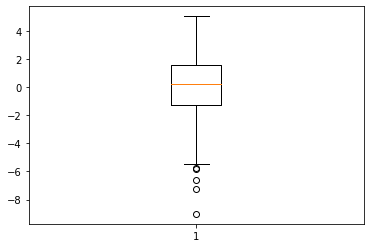

In [97]:
pd_train = train.as_data_frame()
plt.boxplot(pd_train['refactoring_perc_time_taken_log'])

In [98]:
test.head()

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken_log
21,21,21,0,2,2,2,0,1,1,1,0,11,11,11,0,0,0,0,0,2,2,2,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,52,52,52,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,6,0,0,0,0,0,5,5,5,0,0,0,0,0,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,27,27,0,1,1,1,0,18,42,0.405465
8,8,8,0,4,4,4,0,1,1,1,0,2,2,2,0,6,6,6,0,4,4,4,0,1,1,1,0,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,33,33,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,39,39,39,0,1,1,1,0,10,41,2.25732
4.7554,3,12,1.92181,2.15108,2,3,0.359421,3.1223,3,4,0.328819,5.71942,5,15,1.67691,0.942446,0,3,0.561698,2.15108,2,3,0.359421,0.0791367,0,1,0.270928,0.028777,0,1,0.167784,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.172662,0,2,0.415777,0.0791367,0,1,0.270928,0,0,0,0,0.172662,0,2,0.415777,0,0,0,0,0,0,0,0,0.0215827,0,1,0.145842,0,0,0,0,0.553957,0,7,1.16204,15.7914,14,26,2.99631,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.697842,0,4,1.17124,0.446043,0,4,0.964385,0.179856,0,2,0.421381,0,0,0,0,0.179856,0,2,0.421381,0,0,0,0,0,0,

In [99]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken_log']
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken_log']

In [100]:
pd_preds.head()

,predict,actual_time_taken
0,0.646904,0.405465
1,0.021934,2.257319
2,-0.084661,-3.416235
3,-0.130738,-1.591500
4,0.937499,1.609438


In [101]:
pd_preds

,predict,actual_time_taken
0,0.646904,0.405465
1,0.021934,2.257319
2,-0.084661,-3.416235
3,-0.130738,-1.591500
4,0.937499,1.609438
...,...,...
149,-0.047835,3.871201
150,0.918738,0.461154
151,-2.210062,-5.440974
152,0.806899,1.386294


{'whiskers': [<matplotlib.lines.Line2D at 0x2083e8cb6a0>,
 'caps': [<matplotlib.lines.Line2D at 0x2083e8cbdd8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2083e8cb550>],
 'medians': [<matplotlib.lines.Line2D at 0x2083e8a2518>],
 'fliers': [<matplotlib.lines.Line2D at 0x2083e8a2898>],
 'means': []}

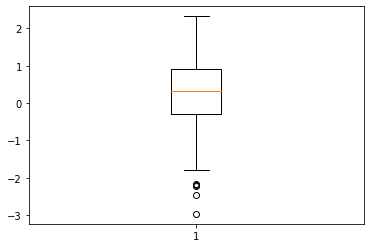

In [102]:
plt.boxplot(pd_preds['predict'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2083e914b00>,
 'caps': [<matplotlib.lines.Line2D at 0x2083e922240>,
 'boxes': [<matplotlib.lines.Line2D at 0x2083e9149b0>],
 'medians': [<matplotlib.lines.Line2D at 0x2083e922940>],
 'fliers': [<matplotlib.lines.Line2D at 0x2083e922cc0>],
 'means': []}

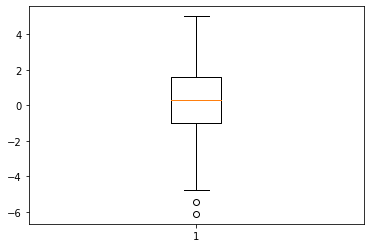

In [103]:
plt.boxplot(pd_preds['actual_time_taken'])

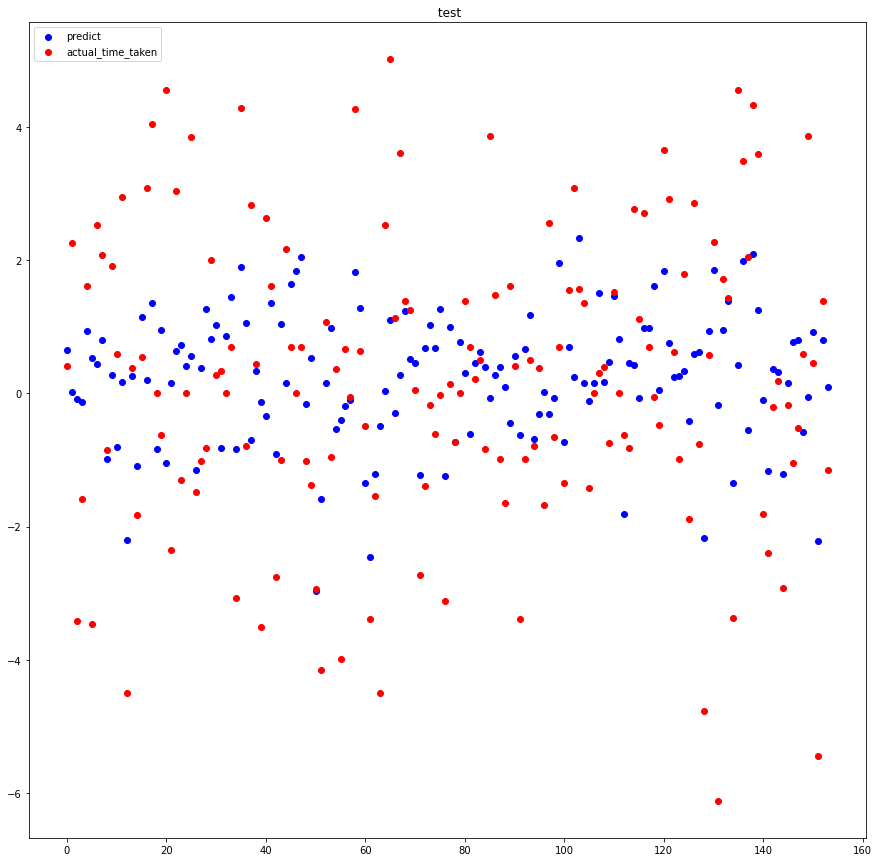

In [104]:
plotGraph(pd_preds['predict'], pd_preds['actual_time_taken'],'predict','actual_time_taken',' test')

In [105]:
visualization = pd_preds[pd_preds['predict'] <= 20]
visualization = pd_preds[pd_preds['actual_time_taken'] <= 20]


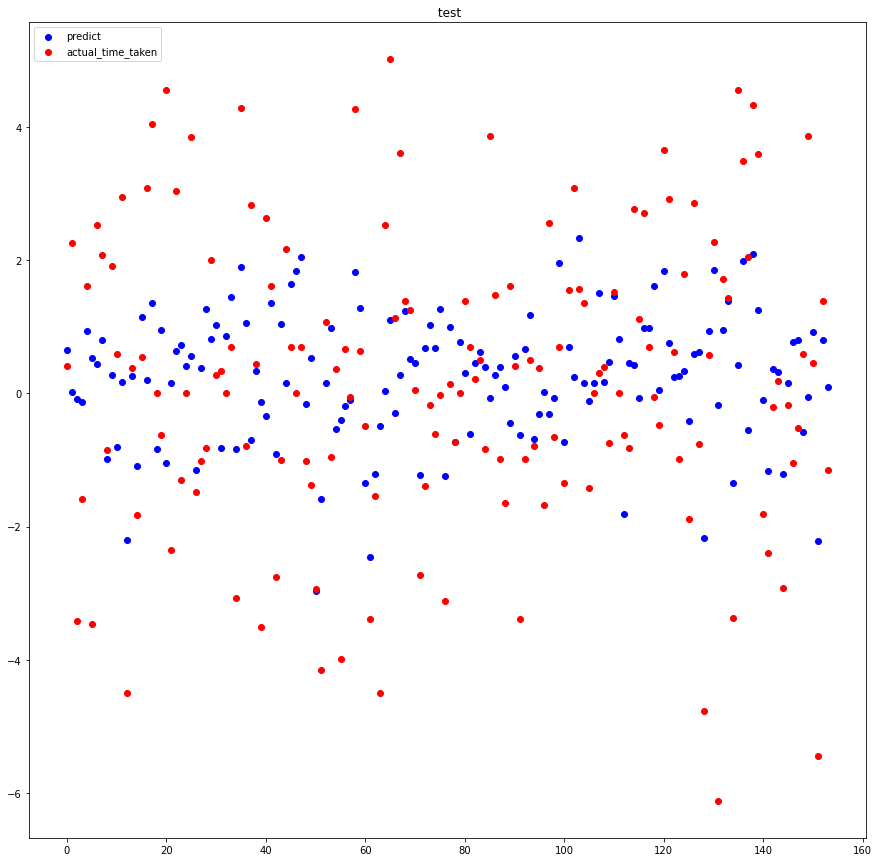

In [106]:
plotGraph(visualization['predict'], visualization['actual_time_taken'],'predict','actual_time_taken',' test')

Text(0.5, 1.0, 'Actual vs Predicted')

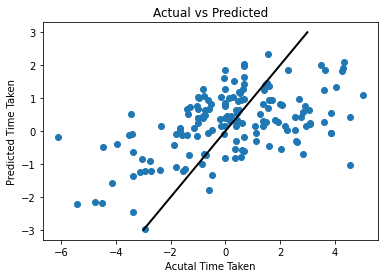

In [108]:
import matplotlib.pyplot as plt
plt.scatter(pd_preds['actual_time_taken'], pd_preds['predict'])
#plt.plot([-3, 3], [-3, 3], color = 'black', linewidth = 2)
plt.xlabel('Acutal Time Taken')
plt.ylabel('Predicted Time Taken')
plt.title('Actual vs Predicted')

In [109]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv3", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

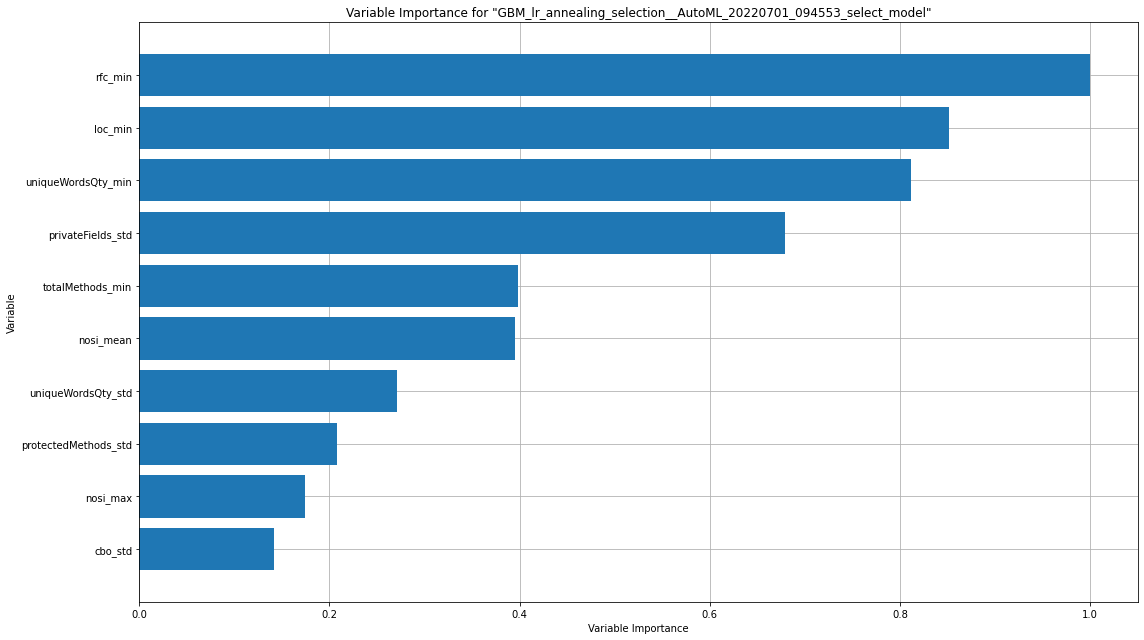

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

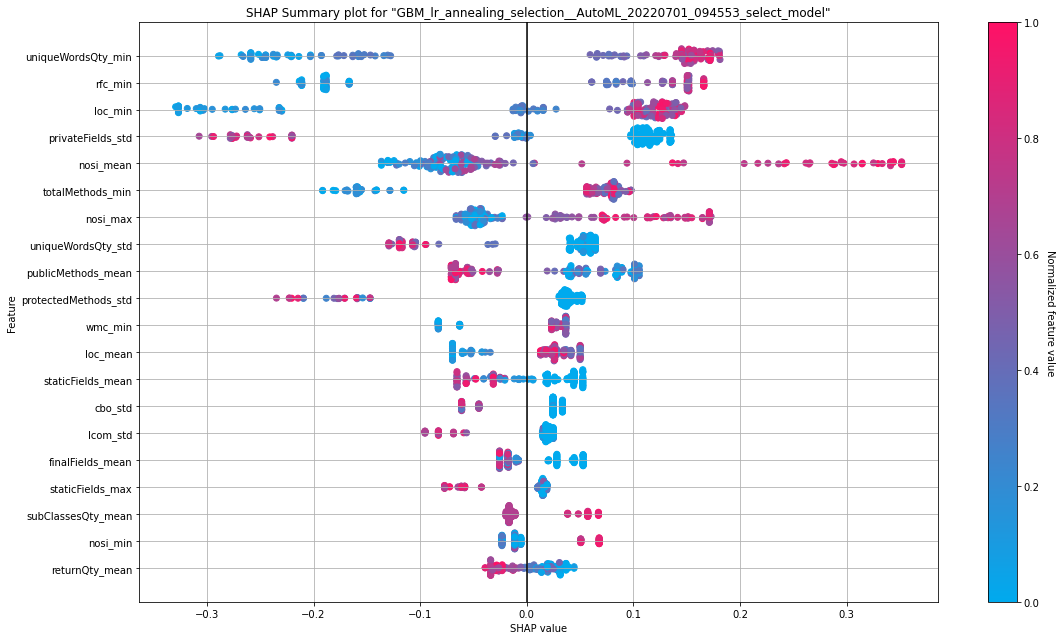

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

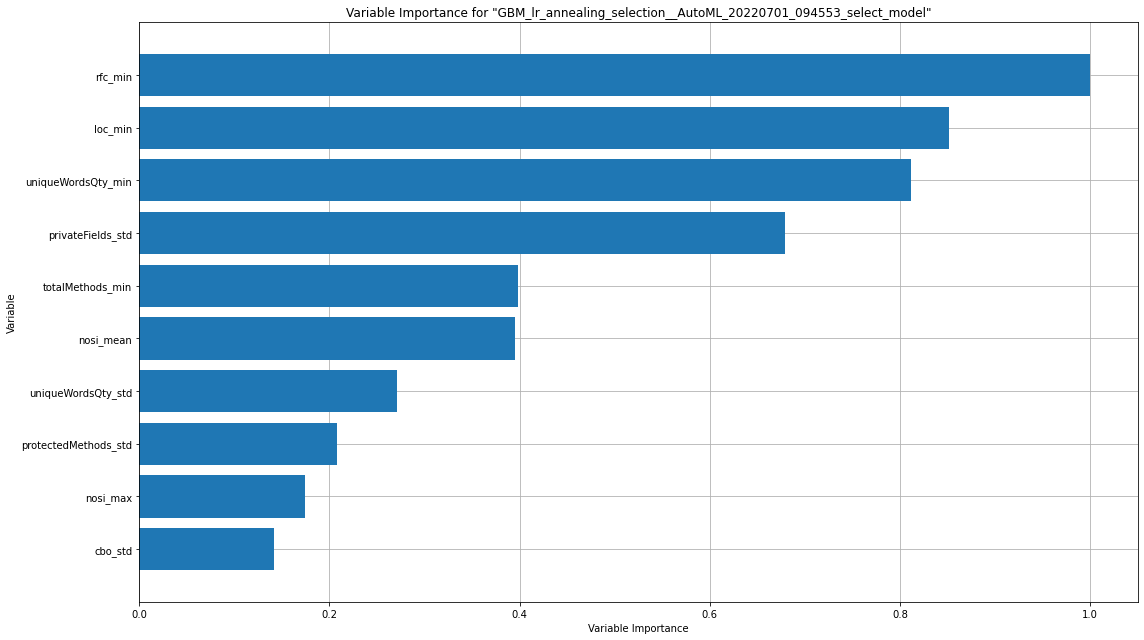

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

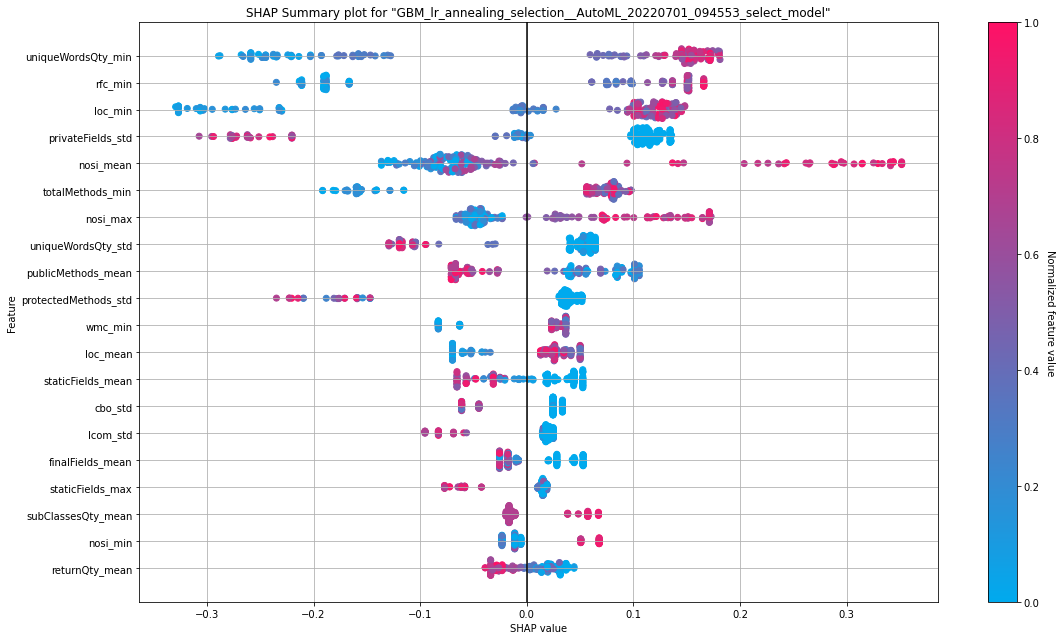

In [110]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [40]:
## Test calling of model

model_path = "models/EffortEstimationModelv3/Log_Regression_GBM_grid__1_AutoML_20220228_154246_model_3"
model = h2o.load_model(model_path)

In [45]:
test.head()

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken_log
25,25,25,0,32,32,32,0,1,1,1,0,65,65,65,0,9,9,9,0,23,23,23,0,1,1,1,0,18,18,18,0,4,4,4,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,7,7,7,0,3,3,3,0,1,1,1,0,4,4,4,0,2,2,2,0,0,0,0,0,4,4,4,0,0,0,0,0,46,46,46,0,265,265,265,0,6,6,6,0,0,0,0,0,0,0,0,0,10,10,10,0,0,0,0,0,80,80,80,0,14,14,14,0,49,49,49,0,32,32,32,0,48,48,48,0,2,2,2,0,0,0,0,0,0,0,0,0,1,1,1,0,166,166,166,0,1025,1025,1025,0,51,321,-0.144761
15,15,15,0,3,3,3,0,1,1,1,0,21,21,21,0,3,3,3,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,64,64,64,0,100,100,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99,99,99,0,0,0,0,0,7,7,7,0,4,4,4,0,7,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,51,51,51,0,0,0,0,0,11,104,1.56582
0,0,0,0,1,1,1,0,4,4,4,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,7,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12,0,17,17,17,0,121,6,1.22223
11,11,11,0,6,6,6,0,2,2,2,0,10,10,10,0,15,15,15,0,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
preds_read_model = model.predict(test)
pd_preds_read_model = preds_read_model.as_data_frame()
pd_preds_read_model['actual_time_taken'] = test['refactoring_perc_time_taken_log']

In [ ]:
pd_preds_read_model.head(15)

In [95]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


print(r2_score(pd_preds_read_model['actual_time_taken'], pd_preds_read_model['predict']))
print(r2_score(np.exp(pd_preds_read_model['actual_time_taken']), np.exp(pd_preds_read_model['predict'])))
print(mean_squared_error(pd_preds_read_model['actual_time_taken'], pd_preds_read_model['predict'],squared=False))
print(mean_squared_error(np.exp(pd_preds_read_model['actual_time_taken']), np.exp(pd_preds_read_model['predict'])))

0.2659565181450615
-0.022268789833443492
1.9671359300646738
236.59453958390492


In [ ]:
plotGraph(pd_preds_read_model['predict'], pd_preds_read_model['actual_time_taken'],'predict','actual_time_taken',' test')

In [96]:
print(mean_squared_error(pd_preds_read_model['actual_time_taken'], pd_preds_read_model['predict'],squared=False))

1.9671359300646738


In [97]:
pd_preds_read_model

,predict,actual_time_taken
0,1.185453,-0.144761
1,1.870472,1.565823
2,-0.609796,1.222226
3,1.439150,2.014903
4,-0.709079,-0.370219
...,...,...
149,-1.709463,-3.832258
150,-0.830488,-7.277040
151,0.174653,0.234138
152,-0.087386,2.046219
